In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

importing imfits from D:\L1489_IRS_ssp\imfits


In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
res_prefix = 'rs_empkep_fixr_rms_SLAM_vcut_lwerN_bnds_high_tbnds_69_sf_bf_no_approx' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [4]:
def emp_kep_v(v_rot, v_100, p):        
        r_au = 100.*np.power(v_100/v_rot, 1/p)
        return r_au

def emp_kep_r(r,r_b, v_100, p):
        v_r = v_100*(r/100)**(-p)
        return v_r

In [16]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], 
                 tb7:float=10., tb6:float=8.,
                 tb7_err:float=1.08,
                 tb6_err:float=0.49, 
                 figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.sort(np.array([5.e11, Ncol[1], 1.e19, 1.5*Ncol[1]])) # cm^-2  
    Texes = np.sort(np.array([5, Texe[1],30., 60, 1.5*Texe[1]])) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []
    Taunu_7_pred = []
    Taunu_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None))
            Taunu_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None, return_tau = True))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None))
            Taunu_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None, return_tau = True) )

            
    # Get theoretical errors at median values
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=None, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=None, return_errs = True)
    

    #print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    #print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    #print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    #print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    #print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    #print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    #print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])


    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    #print("Error propagation results:")
    #print(r"$\Delta Tb_{6}$", Tb6_thr_err)
    #print(r"$\Delta Tb_{7}$", Tb7_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    Taunu_7_err = np.array([[Taunu_7_pred[4] - min(Taunu_7_pred), max(Taunu_7_pred) - Taunu_7_pred[4]]])
    Taunu_6_err = np.array([[Taunu_6_pred[4] - min(Taunu_6_pred), max(Taunu_6_pred) - Taunu_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit', capsize=5.)
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    

    print("In LTE funcction tb7 error is", tb6_err)
    
    ax.errorbar(tb7, tb6, xerr = tb7_err,   # (0.1*tb7)**2 + 1.08**2
                yerr = tb6_err,  # (0.1*tb6)**2 + 0.49**2
                color = 'red', marker = 'o', ms=5, capsize=5., label = 'Observed')
    
    ul = np.max([tb6, tb7, Texe[1]])
    ax.set_ylim(0,ul)
    ax.set_xlim(0,ul)

    plt.grid()
    plt.legend(prop={'size': 6})

    return fig, ax, (Tb_6_pred[4], Tb_6_err, Taunu_6_pred[4], Taunu_6_err),\
          (Tb_7_pred[4], Tb_7_err, Taunu_7_pred[4], Taunu_7_err)

In [6]:
def bff_function(a,p,r):

    return 1. - np.exp(- a * np.power(r,p))

def beam_dilution_correction(Tb, r, Tb_err):

    a = 1.1321e-01
    p = 1.8575e+00
    bff_err = 0.09
    bff = bff_function(a,p,r)
    
    Tb_corrected = Tb/bff
    Tb_corr_err = np.sqrt((Tb_err/bff)**2 + bff_err**2)

    return Tb_corrected, Tb_corr_err, bff, bff_err

In [7]:
from astropy import constants
clight = constants.c.cgs.value        # light speed (cm s^-1)
kb     = constants.k_B.cgs.value      # Boltzman coefficient
hp     = constants.h.cgs.value        # Planck constant
sigsb  = constants.sigma_sb.cgs.value # Stefan-Boltzmann constant (erg s^-1 cm^-2 K^-4)

def IvTOTex(Iv, nu0, bmaj, bmin, sigI=None):
    '''
    Convert Iv to Tb WITHOUT Rayleigh-Jeans approximation.

    Parameters
    ----------
        nu0 (float): Rest frequency [Hz]
        bmaj (float): Major beam size [deg]
        bmin (float): Minor beam size [deg]
        Iv (array or float): Intensity [Jy/beam]
        sigI (array or float): Sigma of intensity [Jy/beam]

    Others
    ------
        C1: coefficient to convert Iv to Tex
        C2: coefficient to convert beam to str
    '''

    bmaj = bmaj*np.pi/180. # deg --> radian
    bmin = bmin*np.pi/180. # deg --> radian

    C1=2.*hp*(nu0*nu0*nu0)/(clight*clight) # in cgs

    # Jy/beam -> Jy/str
    # Omg_beam (str) = (pi/4ln(2))*beam (rad^2)
    # I [Jy/beam] / Omg_beam = I [Jy/str]
    C2 = np.pi/(4.*np.log(2.))  # beam(rad) -> beam (sr)
    bTOstr = bmaj*bmin*C2  # beam --> str
    Istr = Iv/bTOstr # Jy/beam --> Jy/str
    Istr = Istr*1.0e-26 # Jy --> MKS (Jy = 10^-26 Wm-2Hz-1)
    Istr = Istr*1.e7*1.e-4 # MKS --> cgs

    Tex = (hp*nu0/kb)/(np.log(C1/Istr + 1.)) # no approximation [K]

    if sigI is not None:
        # Error propagation
        dT_dI = (hp*nu0/kb) * C1 * (Istr**(-2.)) * (C1/Istr + 1.)**(-1.) \
        * (np.log(C1/Istr + 1.))**(-2) # derivative
        sigI_str = sigI / bTOstr * 1.0e-26 * 1.e7 * 1.e-4
        sigTex = np.sqrt(dT_dI*dT_dI*sigI_str*sigI_str)

        return Tex, sigTex
    else:
        return Tex


### Temperature estimation (fix v)

#### Read the Data

In [5]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [6]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674},)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674})

NameError: name 'emp_kep_v' is not defined

In [ ]:
v_100 = 2.674
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

#### Data Visualization

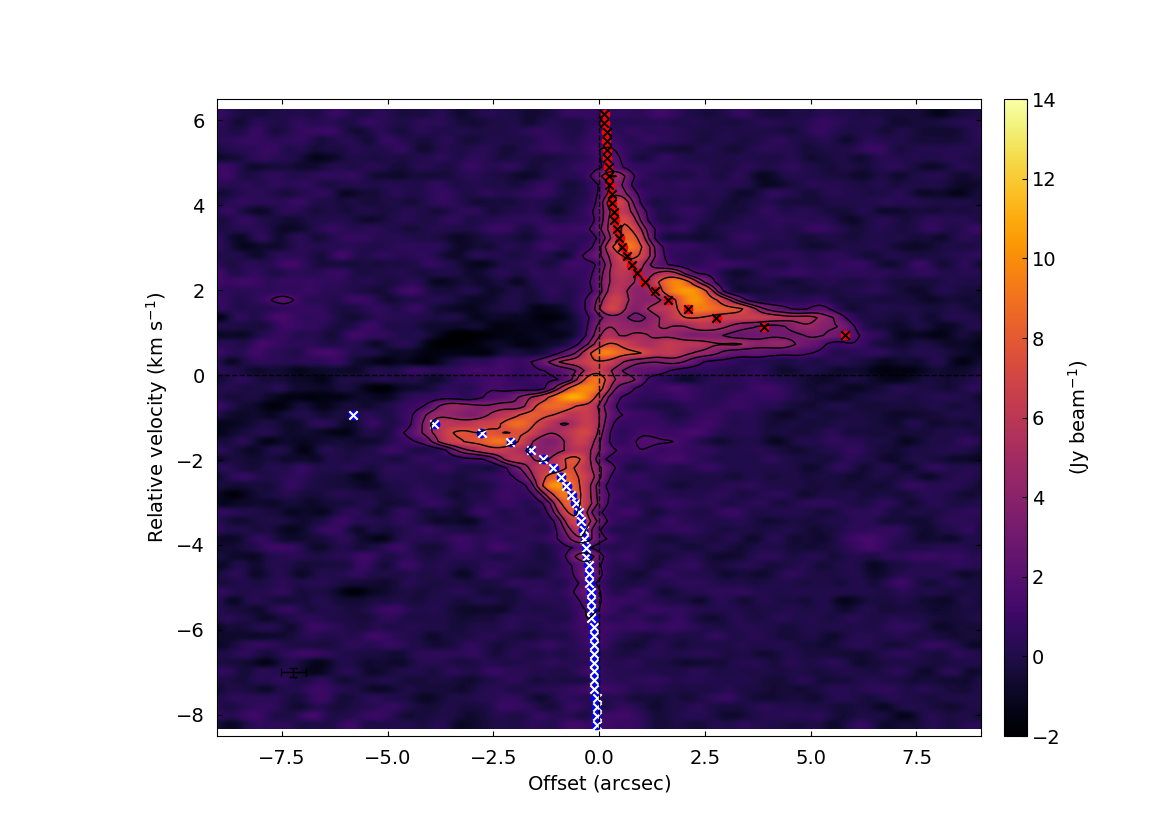

In [8]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop(fix v)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.094e-01 arcsec, v =  4.06 Kmps , Tb7 = 7.1, Tb6 = 6.2


100%|██████████| 10000/10000 [00:13<00:00, 724.85it/s]


11.5 21.5 4.0 4.8
17.7 21.5 6.4 5.9
35.4 21.5 7.8 5.1
11.5 21.7 4.5 5.4
17.7 21.7 7.5 7.0
35.4 21.7 9.7 6.4
11.5 23.5 5.3 6.8
17.7 23.5 10.9 12.7
35.4 23.5 28.0 30.2


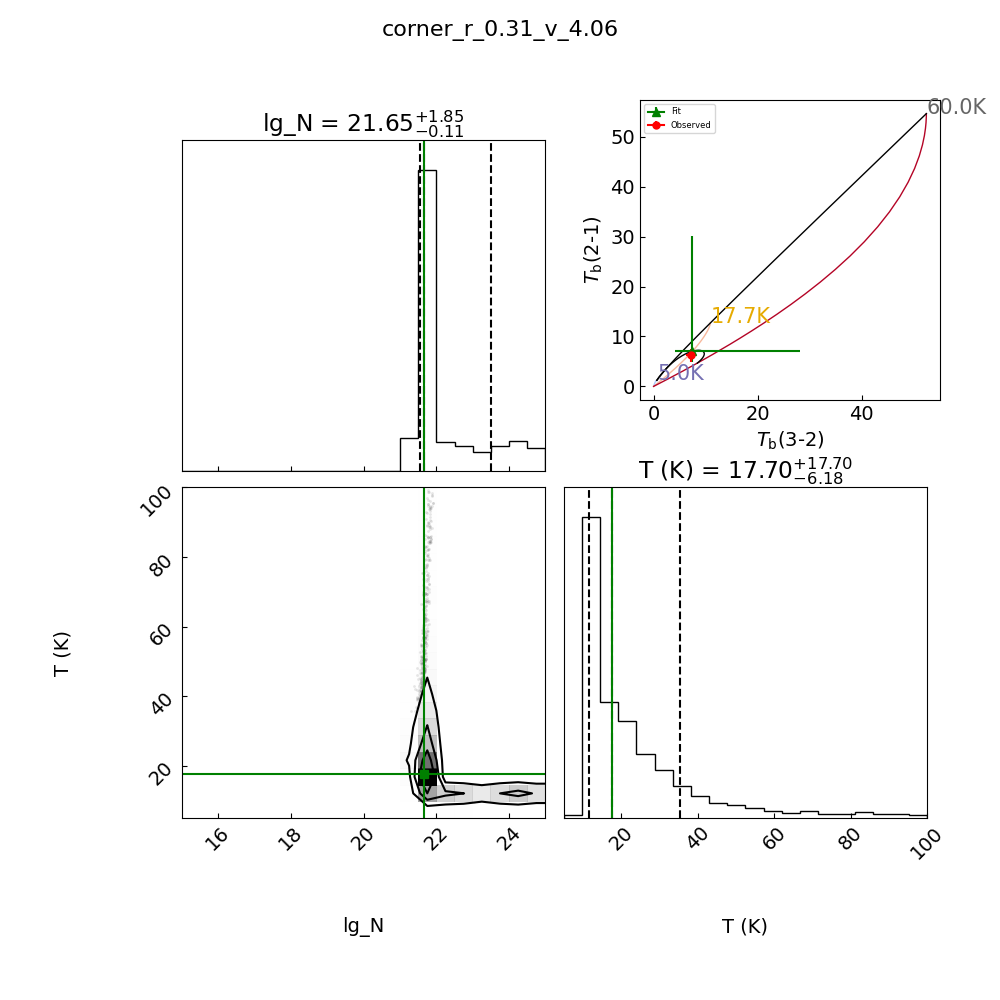

In [36]:
Texe_rs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_rs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "redshifted_points_empkep_test"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_sur_pt_rs"][15:16], Tb_df_b6["Tb_sur_pt_rs"][15:16], 
                          pv_b6.r_as_rs[15:16], pv_b6.v_rot_redshifted[15:16]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_rs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_rs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_empkep_rs = [np.array(Texe_rs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_rs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_rs = [np.array(Ncol_rs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_rs_empkep)]

In [ ]:
results_data = {"r_empkep_rs": pv_b6.r_as_rs,
        "Tb7_empkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep" : Texe_rs_empkep, "Texe_err_rs_empkep" : np.array(T_err_empkep_rs).T.tolist(),
        "Ncol_rs_empkep" : Ncol_rs_empkep, "Ncol_err_rs_empkep" : np.array(N_err_empkep_rs).T.tolist()
        }

print(np.shape(T_err_empkep_rs))
print(len(pv_b6.r_as_rs), len(Tb_df_b7["Tb_on_point_rs"]), len(Tb_df_b6["Tb_on_point_rs"]), len( Ncol_rs_empkep),
      len(N_err_empkep_rs))
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

(2, 26)
26 26 26 26 2


#### Visualize results

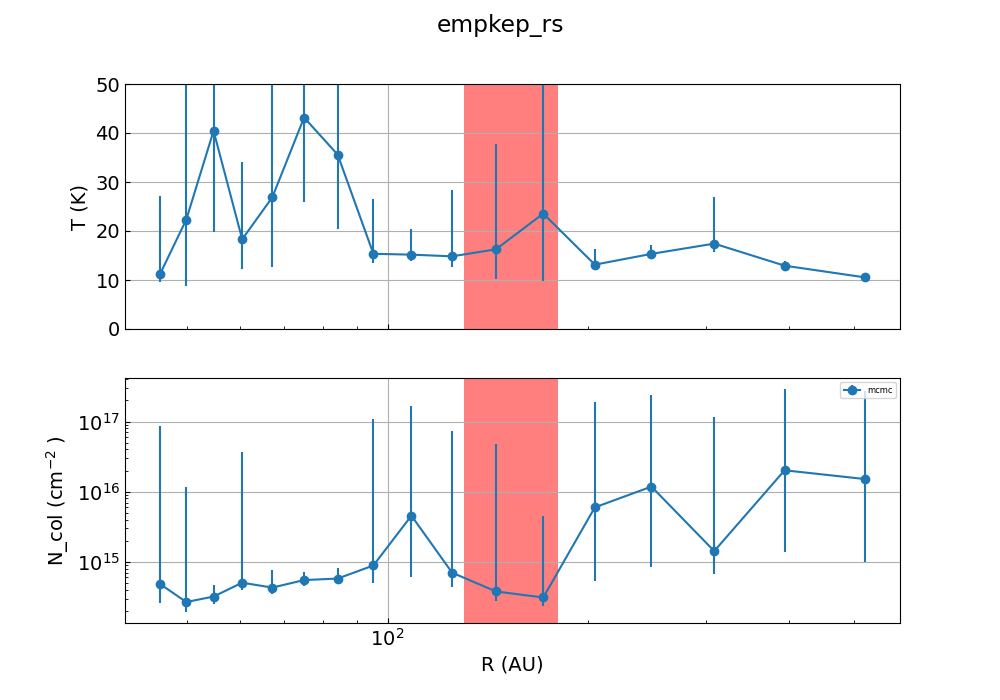

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]

ftd_r_as_rs, ftd_Texe_rs_empkep, ftd_Terr_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_empkep, np.array(T_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[0].errorbar(np.array(ftd_r_as_rs)*140., ftd_Texe_rs_empkep, yerr=np.array(ftd_Terr_rs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_empkep, ftd_N_err_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep, np.array(N_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs)*140., np.array(ftd_Ncol_rs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')

axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Read the Data

In [8]:
v_sys_b6=7.386 #kmps
v_100_b6 = 2.797
p_index_b6 = 0.511

v_sys_b7=7.289
v_100_b7 =2.811
p_index_b7 = 0.464

v_sys_avg = (v_sys_b6+v_sys_b7)/2
print(v_sys_avg)
v_100_avg = (v_100_b7 + v_100_b6)/2
print(v_100_avg)
p_index_avg = (p_index_b7 + p_index_b6)/2
print(p_index_avg)

is_Tb = False


# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=is_Tb, v_sys=v_sys_avg) # V_sys - 7.22, 7.27 7.384
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    is_Tb=is_Tb, v_sys=v_sys_avg)
pv_b6.read_pv(print_details = True)



7.3375
2.8040000000000003
0.48750000000000004
Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$


In [9]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = v_100_avg #kmps # idpft-2.674 # JS- 3.2 # newft 2.842, 54ft 3.138
p = p_index_avg

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100_avg, p=p_index_avg)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [10]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100, p=p_index_avg)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [11]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

#### Data Visualization

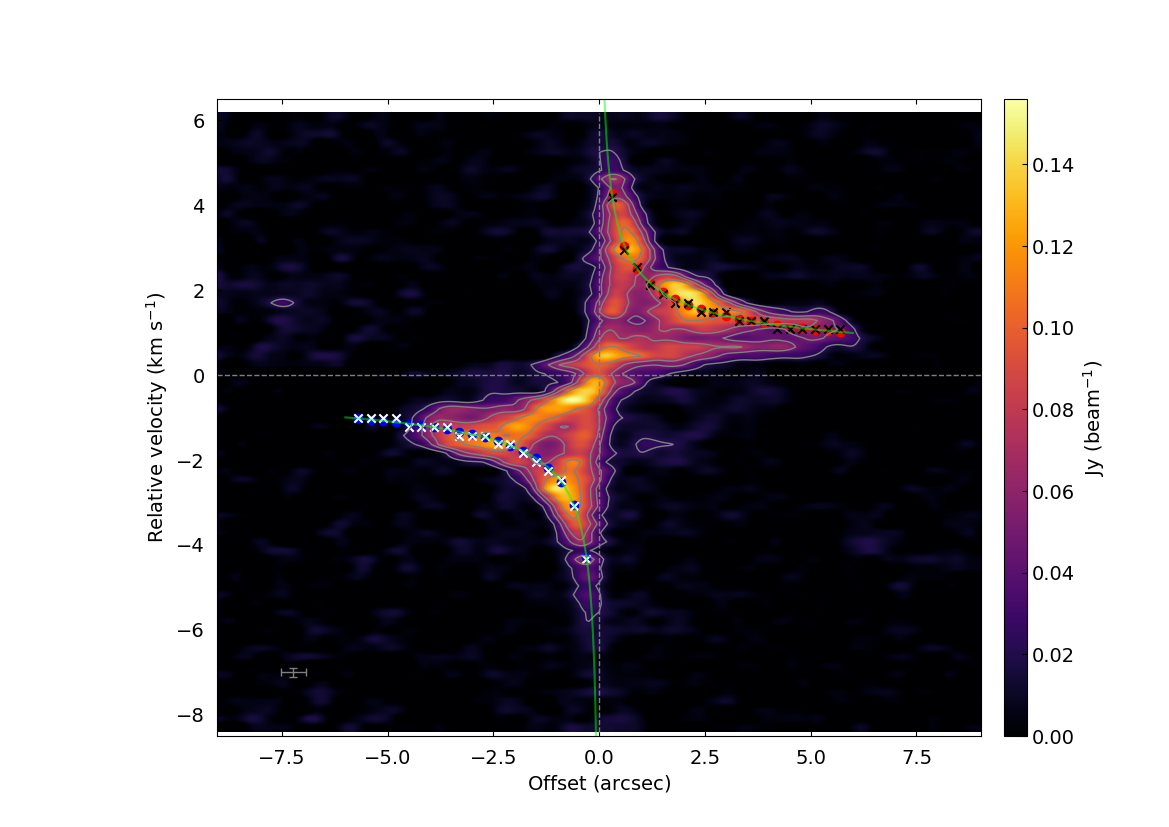

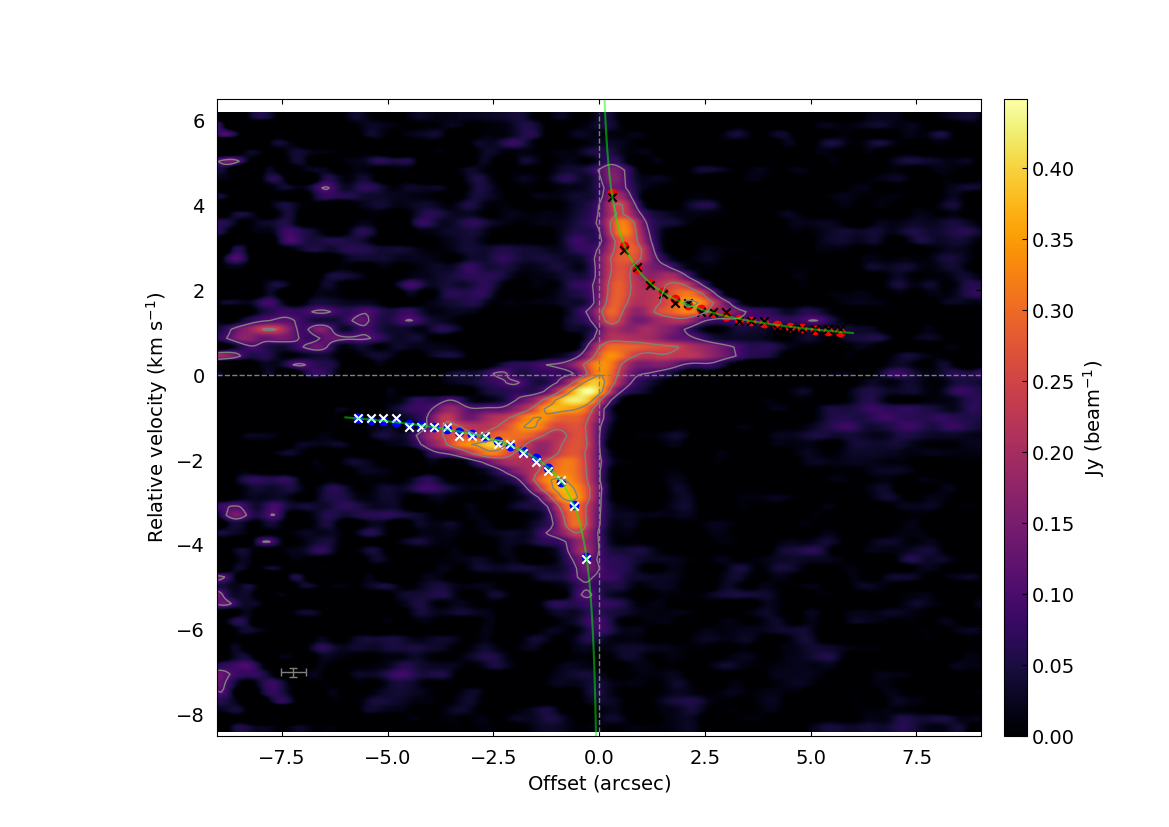

In [12]:

pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_dia7 = pv_b7.plot_pv(plot_curve=True)
pv_dia7[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia7[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

#### T estimation loop (fix r)

In [13]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

349.3383786198865
41.05564246198009
estimating for r = 3.000e-01 arcsec, v =  4.28 Kmps , Tb7 = 0.2, Tb6 = 0.1,
           Tb7_corrected = 478.7, Tb6_corrected = 349.3
dtauv_dT =  3.958954434964884e-07
dtauv_dT =  9.551182544523714e-08
In LTE funcction tb7 error is 41.05564246198009


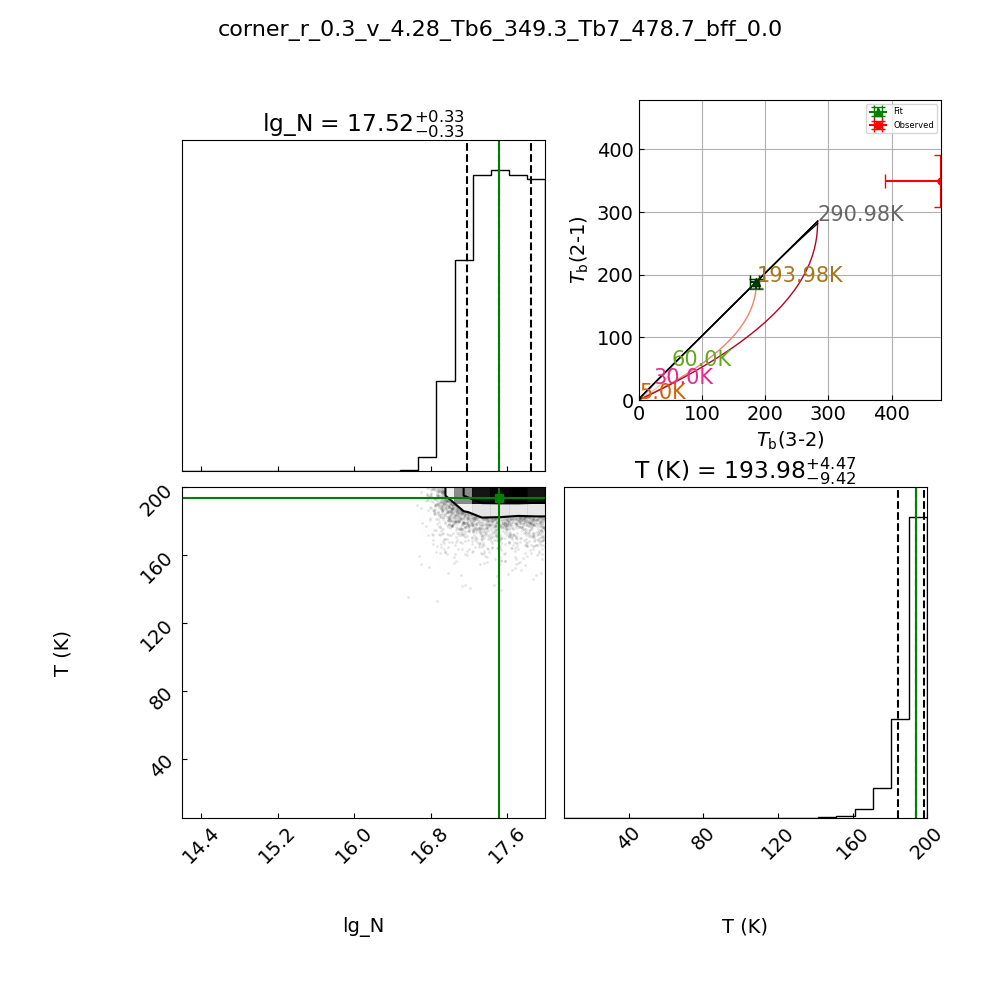

In [19]:
op_dir_label = res_prefix

Texe_rs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_rs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

Tb_6_predictions = []
Tb_7_predictions = []

beam_filling_factor_tb6 = []
beam_filling_factor_tb6_err = []
beam_filling_factor_tb7 = []
beam_filling_factor_tb7_err = []


plot_corner = True

np.random.seed(41)

# N_conv_fraction = 1.e-7
lg_n_bounds = [14.2,18]
T_bounds = [5.,200.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])


ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"][0:1],
                           Tb_df_b6["Tb_on_point_rs"][0:1], 
                          pv_b6.r_as_rs[0:1], pv_b6.v_rot_redshifted[0:1]):

     Tb7_corrected, Tb7_err, bff_tb7, bff_tb7_err = beam_dilution_correction(Tb = float(Tb7), 
                                                                             r=abs(float(r)), 
                                                                             Tb_err=pv_b7.rms)
     Tb6_corrected, Tb6_err, bff_tb6, bff_tb6_err = beam_dilution_correction(Tb = float(Tb6), 
                                                                             r=abs(float(r)), 
                                                                             Tb_err=pv_b6.rms)

     if not is_Tb:
         # If intensity values are not read in units of Tb then we must convert it after beam dilution factor correction
         
         nu_7 = (1 - ((v+v_sys_avg)*1.e3/3e8))*329.3305525e9  # conver velocity to mks
         Tb7_corrected, Tb7_err = IvTOTex(Iv=Tb7_corrected, nu0 = nu_7 , 
                                          bmaj=0.6/3600, bmin=0.6/3600, sigI=Tb7_err)
         
         
         nu_6 = (1 - ((v+v_sys_avg)*1.e3/3e8))*219.5603541e9
         Tb6_corrected, Tb6_err = IvTOTex(Iv=Tb6_corrected, nu0 = nu_6 , 
                                          bmaj=0.6/3600, bmin=0.6/3600, sigI=Tb6_err)


     print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f},\n \
          Tb7_corrected = {Tb7_corrected:.1f}, Tb6_corrected = {Tb6_corrected:.1f}")

     flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7_corrected, t2=Tb6_corrected, 
                                                    s1=Tb7_err, # + 1.08**2 + (0.1*Tb7)**2
                                                    s2=Tb6_err, #  (0.1*Tb6)**2 + 0.49**2
                                                    estimator='mcmc', like_function = 'chisq', 
                                                    initial_params = [lg_n_init, T_init], 
                                                    bounds=(lg_n_bounds[0], lg_n_bounds[-1], 
                                                            T_bounds[0], T_bounds[-1]), 
                                                    initial_scatter = 0.1, args= None,
                                                    nwalkers = 50, n_steps = 9000, burn_in = 2000, thin_by = 50, 
                                                    return_flat= True, intensity_model = lte_model, plot_chain = True, 
                                                    r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                    chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                                    "chains",op_dir_label),
                                                    show_chains = False)
    
     flat_samples_N = flat_samples[:, 0]
     flat_samples_T = flat_samples[:, 1]
    
     T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
     Texe_lq_empkep_fix_r.append(T_qtls[0])
     Texe_rs_empkep_fix_r.append(T_qtls[1])
     Texe_upq_empkep_fix_r.append(T_qtls[2])

     Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
     Ncol_qtls = (10**Ncol_qtls)
     Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
     Ncol_rs_empkep_fix_r.append(Ncol_qtls[1])
     Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

     beam_filling_factor_tb6.append(bff_tb6)
     beam_filling_factor_tb6_err.append(bff_tb6_err)
     beam_filling_factor_tb7.append(bff_tb7)
     beam_filling_factor_tb7_err.append(bff_tb7_err)

    

     if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7_corrected, tb6=Tb6_corrected, 
                                tb7_err=Tb7_err,
                                tb6_err=Tb6_err,                                
                                figure = fig1,
                                axes = ax)
        
        Tb_6_predictions.append(Tb_6_prediction)
        Tb_7_predictions.append(Tb_7_prediction)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)) + '_Tb6_' 
                      + str(round(Tb6_corrected,1))+ 
                      '_Tb7_' + str(round(Tb7_corrected,1))+ '_bff_' +
                        str(round(Tb7/Tb7_corrected,3)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

     ctr = ctr+1


In [15]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [16]:
# Prepare result arrays
Tb6_prediction_median = [tupple[0] for tupple in Tb_6_predictions]
Tb6_prediction_errs = [tupple[1] for tupple in Tb_6_predictions]
Tau_nu_b6 = [tupple[2] for tupple in Tb_6_predictions]
Tau_nu_errs_b6 = [tupple[3] for tupple in Tb_6_predictions]

Tb7_prediction_median = [tupple[0] for tupple in Tb_7_predictions]
Tb7_prediction_errs = [tupple[1] for tupple in Tb_7_predictions]
Tau_nu_b7 = [tupple[2] for tupple in Tb_7_predictions]
Tau_nu_errs_b7 = [tupple[3] for tupple in Tb_7_predictions]

In [17]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"],
        "Tb7_empkep_rs_fix_r_prediction": Tb7_prediction_median, 
        "Tb7_empkep_rs_err_qtl" : Tb7_prediction_errs,
        "bff_tb7": beam_filling_factor_tb7,
        "bff_err_tb7":beam_filling_factor_tb7_err,        
        "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Tb6_empkep_rs_fix_r_prediction": Tb6_prediction_median,
        "Tb6_empkep_rs_err_qtl" : Tb6_prediction_errs,
        "bff_tb7": beam_filling_factor_tb6,
        "bff_err_tb7":beam_filling_factor_tb6_err,
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, 
        "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, 
        "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist(),
        "Tau_nu_b6" : Tau_nu_b6,
        "Tau_nu_errs_b6" : Tau_nu_errs_b6,
        "Tau_nu_b7" : Tau_nu_b7,
        "Tau_nu_errs_b7" : Tau_nu_errs_b7
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

d:\L1489_IRS_ssp\LTEAnalysis\rs_empkep_fixr_rms_SLAM_vcut_lwerN_bnds_high_tbnds_sf_bf_RJ_approx.csv


#### Visualize results

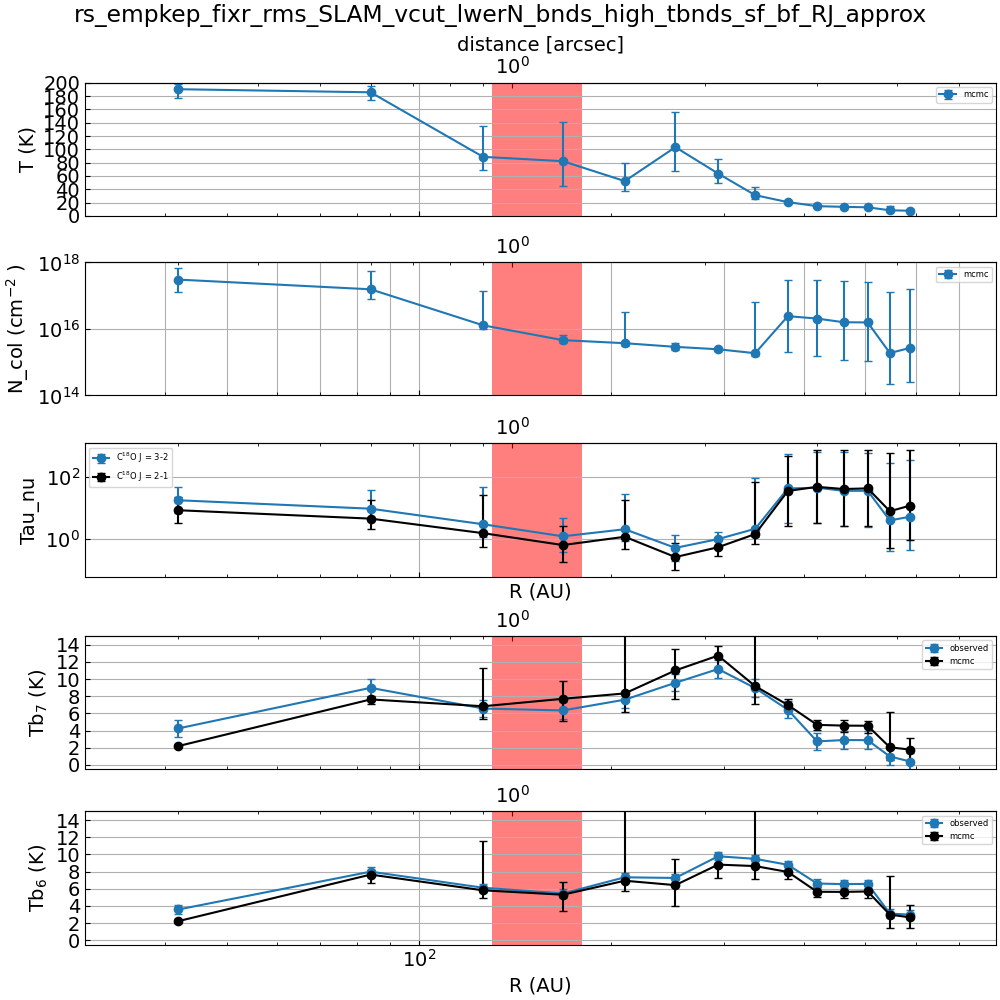

In [27]:
N_conv_fraction = 1.
vis_results_fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True, layout="constrained")


acceptable_r_range = [0.3, 4.2]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, \
            ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: 
                                                   acceptable_r_range[0] <= triple[0] <= acceptable_r_range[1], 
                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                    np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc', capsize = 3.)
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[0].set_ylim(0,200)
axes[0].set_yticks([0,20,40,60,80,100,120,140,160,180,200])
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

secax_0 = axes[0].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax_0.set_xlabel('distance [arcsec]')

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc', capsize = 3.)
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim((1.e14,1.e18))
axes[1].grid(True, which = 'both')
axes[1].legend(prop={'size': 6})

secax_1 = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
#secax_1.set_xlabel('distance [arcsec]')


ftd_r_as_bs_fix_r, ftd_Tauvu_6_bs_empkep_fix_r, \
    ftd_Tauvu_6_bs_err_empkep_fix_r = zip(*[(r, tau_6, tau6_err) for r, tau_6, tau6_err in 
                                        zip(pv_b6.r_as_rs, Tau_nu_b6, 
                                            np.array(Tau_nu_errs_b6).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

ftd_r_as_bs_fix_r, ftd_Tauvu_7_bs_empkep_fix_r, \
    ftd_Tauvu_7_bs_err_empkep_fix_r = zip(*[(r, tau_7, tau7_err) for r, tau_7, tau7_err in 
                                        zip(pv_b7.r_as_rs, Tau_nu_b7, 
                                            np.array(Tau_nu_errs_b7).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_7_bs_empkep_fix_r), 
                 yerr=np.array(np.squeeze(ftd_Tauvu_7_bs_err_empkep_fix_r)).T, 
                 marker='o', label = r'C$^{18}$O J = 3-2', capsize = 3.)
axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_6_bs_empkep_fix_r), 
                 yerr=np.array(np.squeeze(ftd_Tauvu_6_bs_err_empkep_fix_r)).T, 
                 marker='o', label = r'C$^{18}$O J = 2-1', capsize = 3., c='k')
axes[2].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[2].set_ylabel(r"Tau_nu")
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True)
axes[2].legend(prop={'size': 6})
axes[2].set_xlabel("R (AU)")
secax_2 = axes[2].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))

ftd_r_as_rs_fix_r, ftd_Tb7_rs_empkep_fix_r, \
    ftd_Tb7_rs_empkep_fix_r_prediction,\
    ftd_Tb7_rs_empkep_fix_r_prediction_err,\
         ftd_bff, ftd_bff_err = zip(*[(r, Tb7, Tb7_pred, Tb7_pred_err, bff, bff_err) 
                                                   for r, Tb7, Tb7_pred, Tb7_pred_err, bff, bff_err in 
                                                    zip(pv_b7.r_as_rs, Tb_df_b7["Tb_on_point_rs"], 
                                                        Tb7_prediction_median,
                                                        np.array(Tb7_prediction_errs).tolist(),
                                                        beam_filling_factor_tb7, beam_filling_factor_tb7_err) 
                                                    if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[3].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Tb7_rs_empkep_fix_r,
                 yerr=np.ones_like(ftd_Tb7_rs_empkep_fix_r) * 1.01,               
                 marker='o', label = 'observed', capsize = 3.)
axes[3].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.multiply(ftd_Tb7_rs_empkep_fix_r_prediction, ftd_bff), 
                 yerr=np.array(np.squeeze(ftd_Tb7_rs_empkep_fix_r_prediction_err)).T*np.array(ftd_bff),               
                 marker='o', label = 'mcmc', capsize = 3., c='k')
axes[3].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[3].set_ylabel(r"Tb$_{7}$ (K)")
axes[3].set_ylim((-0.5,15))
axes[3].set_yticks([0,2,4,6,8,10,12,14])
axes[3].set_xscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 6})
secax_3 = axes[3].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))


ftd_r_as_rs_fix_r, ftd_Tb6_rs_empkep_fix_r, \
    ftd_Tb6_rs_empkep_fix_r_prediction,\
    ftd_Tb6_rs_empkep_fix_r_prediction_err,\
                    ftd_bff, ftd_bff_err=  zip(*[(r, Tb6, Tb6_pred, Tb6_pred_err, bff, bff_err) 
                                                   for r, Tb6, Tb6_pred, Tb6_pred_err, bff, bff_err in 
                                                    zip(pv_b6.r_as_rs, Tb_df_b6["Tb_on_point_rs"], 
                                                        Tb6_prediction_median,
                                                        np.array(Tb6_prediction_errs).tolist(),
                                                      beam_filling_factor_tb6, beam_filling_factor_tb6_err) 
                                                    if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])


axes[4].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Tb6_rs_empkep_fix_r, 
                 yerr=np.ones_like(ftd_Tb6_rs_empkep_fix_r) * 0.49,               
                 marker='o', label = 'observed', capsize = 3.)
axes[4].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.multiply(ftd_Tb6_rs_empkep_fix_r_prediction, ftd_bff), 
                 yerr=np.array(np.squeeze(ftd_Tb6_rs_empkep_fix_r_prediction_err)).T*np.array(ftd_bff),               
                 marker='o', label = 'mcmc', capsize = 3.,c='k')
axes[4].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[4].set_ylabel(r"Tb$_{6}$ (K)")
axes[4].set_ylim((-0.5,15))
axes[4].set_yticks([0,2,4,6,8,10,12,14])
axes[4].set_xscale('log')
axes[4].grid(True)
axes[4].legend(prop={'size': 6})
secax_4 = axes[4].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))

axes[4].set_xlabel("R (AU)")
axes[4].set_xlim(30,800)



vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')